# Bayesian Optimization with XGBoost (Brian Yuhas)

In [30]:
from pandas import read_feather, read_csv
from pandas import DataFrame
import numpy as np
from math import radians, cos, sin, asin, sqrt

## Read Data

In [31]:
%%time
# Read a subsample (train1) of the original dataset with 55M rows
# It was obtained ramdomly using the command line subsample task:
# >subsample --reservoir -n 1000000 train.csv -r > train1.csv
df = read_feather('tmp/train100K.feather')

CPU times: user 6.46 ms, sys: 6.25 ms, total: 12.7 ms
Wall time: 110 ms


In [32]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,10.5,2015-05-11 11:42:51,-73.978989,40.761620,-73.963959,40.770561,1
1,7.5,2013-10-20 13:27:00,-73.980347,40.763069,-73.988686,40.753979,2
2,4.5,2012-08-04 22:25:00,-74.002281,40.726578,-74.009583,40.723598,2
3,14.5,2011-10-22 23:12:35,-73.932800,40.758900,-73.995003,40.736599,1
4,13.0,2013-11-06 12:44:10,-73.975418,40.761070,-73.998444,40.724892,1


## Clean

In [33]:
# Remove observations with missing values
# Since there are only a few of these, i'm not concerned with imputation
df.dropna(how='any', axis='rows', inplace=True)

# Removing observations with erroneous values
mask = df['pickup_longitude'].between(-75, -73)
mask &= df['dropoff_longitude'].between(-75, -73)
mask &= df['pickup_latitude'].between(40, 42)
mask &= df['dropoff_latitude'].between(40, 42)
mask &= df['passenger_count'].between(0, 8)
mask &= df['fare_amount'].between(0, 250)

df = df[mask]

## Feature Engineering

In [34]:
def dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):  
    distance = np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)
    
    return distance

In [35]:
def transform(data):
    # Extract date attributes and then drop the pickup_datetime column
    data['hour'] = data['pickup_datetime'].dt.hour
    data['day'] = data['pickup_datetime'].dt.day
    data['month'] = data['pickup_datetime'].dt.month
    data['year'] = data['pickup_datetime'].dt.year
    data = data.drop('pickup_datetime', axis=1)

    # Distances to nearby airports, and city center
    # By reporting distances to these points, the model can somewhat triangulate other locations of interest
    nyc = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    data['distance_to_center'] = dist(nyc[1], nyc[0],
                                      data['pickup_latitude'], data['pickup_longitude'])
    data['pickup_distance_to_jfk'] = dist(jfk[1], jfk[0],
                                         data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_jfk'] = dist(jfk[1], jfk[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_ewr'] = dist(ewr[1], ewr[0], 
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_ewr'] = dist(ewr[1], ewr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_lgr'] = dist(lgr[1], lgr[0],
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_lgr'] = dist(lgr[1], lgr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    
    data['long_dist'] = data['pickup_longitude'] - data['dropoff_longitude']
    data['lat_dist'] = data['pickup_latitude'] - data['dropoff_latitude']
    
    data['dist'] = dist(data['pickup_latitude'], data['pickup_longitude'],
                        data['dropoff_latitude'], data['dropoff_longitude'])
    
    return data


df = transform(df)

In [36]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,distance_to_center,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,long_dist,lat_dist,dist
0,10.5,-73.978989,40.761620,-73.963959,40.770561,1,11,11,5,2015,0.074848,0.314224,0.308136,0.267635,0.291607,0.117367,0.094517,-0.015030,-0.008942,0.023972
1,7.5,-73.980347,40.763069,-73.988686,40.753979,2,13,20,10,2013,0.074940,0.317032,0.316280,0.267727,0.250298,0.117275,0.134705,0.008339,0.009090,0.017429
2,4.5,-74.002281,40.726578,-74.009583,40.723598,2,22,4,8,2012,0.016514,0.302475,0.306797,0.209301,0.199020,0.175701,0.185982,0.007301,0.002979,0.010281
3,14.5,-73.932800,40.758900,-73.995003,40.736599,1,23,22,10,2011,0.118317,0.265316,0.305218,0.311104,0.226601,0.073898,0.158401,0.062202,0.022301,0.084503
4,13.0,-73.975418,40.761070,-73.998444,40.724892,1,12,6,11,2013,0.077869,0.310104,0.296951,0.270657,0.211452,0.114346,0.173550,0.023026,0.036179,0.059204


## Train Model

In [37]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,1:].values
y = df.iloc[:,0].values
del df

seed = 101

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3, random_state=seed)

In [38]:
%%time
from sklearn.ensemble import ExtraTreesRegressor
#from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score

modelP1 = ExtraTreesRegressor(random_state=seed, n_estimators=20,
                              max_depth = 20, n_jobs = -1)

modelP1.fit(X_train,y_train)

scores = cross_val_score(modelP1, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_error))
print('RMSE CV: %.3f +/- %.3f' % (np.sqrt(np.mean(scores)), np.sqrt(np.std(scores))))

y_pred=modelP1.predict(X_test)
print('RMSE: %.3f' % np.sqrt(mean_squared_error(y_pred,y_test)).round(3))

RMSE CV: 4.013 +/- 0.786
RMSE: 4.236
CPU times: user 25.3 s, sys: 332 ms, total: 25.6 s
Wall time: 4.41 s


In [40]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

In [41]:
dtrain = xgb.DMatrix(X_train, label=y_train)
del(X_train)
dtest = xgb.DMatrix(X_test)
del(X_test)

In [42]:
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=3)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [43]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')

Initialization
----------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth | 
[13:20:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13:20:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:29] src/tree/updater_prune.cc:74: tree 

[13:20:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13:20:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13:20:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:20:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[13:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[13:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[13:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[13:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[13:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[13:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[13:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[13:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[13:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[13:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[13:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[13:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[13:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[13:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_

[13:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[13:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[13:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[13:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[13:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[13:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[13:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[13:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[13:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

[13:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[13:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[13:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[13:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[13:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[13:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 2 pruned nodes, max_depth=5
[13:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[13:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[13:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

[13:20:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[13:20:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[13:20:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[13:20:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[13:20:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[13:20:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[13:20:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[13:20:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[13:20:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[13:20:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[13:20:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:20:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:20:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[13:20:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:20:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[13:20:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:20:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[13:20:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[13:20:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[13:20:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:20:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:20:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_d

[13:20:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[13:20:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[13:20:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[13:20:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 2 pruned nodes, max_depth=7
[13:20:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[13:20:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[13:20:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[13:20:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 4 pruned nodes, max_depth=7
[13:20:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned no

[13:20:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[13:20:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[13:20:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 4 pruned nodes, max_depth=7
[13:20:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 4 pruned nodes, max_depth=7
[13:20:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 2 pruned nodes, max_depth=7
[13:20:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[13:20:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 2 pruned nodes, max_depth=7
[13:20:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 2 pruned nodes, max_depth=7
[13:20:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 2 pruned no

[13:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 6 pruned nodes, max_depth=7
[13:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 2 pruned nodes, max_depth=7
[13:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 4 pruned nodes, max_depth=7
[13:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 6 pruned nodes, max_depth=7
[13:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 4 pruned nodes, max_depth=7
[13:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 2 pruned nodes, max_depth=7
[13:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 2 pruned nodes, max_depth=7
[13:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[13:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 4 pruned node

[13:21:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 10 pruned nodes, max_depth=7
[13:21:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 2 pruned nodes, max_depth=7
[13:21:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 4 pruned nodes, max_depth=7
[13:21:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 2 pruned nodes, max_depth=7
[13:21:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 4 pruned nodes, max_depth=7
[13:21:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 8 pruned nodes, max_depth=7
[13:21:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 4 pruned nodes, max_depth=7
[13:21:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 2 pruned nodes, max_depth=7
[13:21:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nod

[13:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 2 pruned nodes, max_depth=7
[13:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[13:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[13:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[13:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[13:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[13:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[13:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[13:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned no

[13:21:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[13:21:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[13:21:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 2 pruned nodes, max_depth=7
[13:21:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 4 pruned nodes, max_depth=7
[13:21:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 6 pruned nodes, max_depth=7
[13:21:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 2 pruned nodes, max_depth=7
[13:21:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 4 pruned nodes, max_depth=7
[13:21:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 2 pruned nodes, max_depth=7
[13:21:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned no

[13:21:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 2 pruned nodes, max_depth=7
[13:21:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 4 pruned nodes, max_depth=7
[13:21:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 2 pruned nodes, max_depth=7
[13:21:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 2 pruned nodes, max_depth=7
[13:21:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 2 pruned nodes, max_depth=7
[13:21:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 2 pruned nodes, max_depth=7
[13:21:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 2 pruned nodes, max_depth=7
[13:21:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[13:21:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 10 pruned nod

[13:21:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 4 pruned nodes, max_depth=7
[13:21:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[13:21:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 2 pruned nodes, max_depth=7
[13:21:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[13:21:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 8 pruned nodes, max_depth=7
[13:21:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 8 pruned nodes, max_depth=7
[13:21:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 4 pruned nodes, max_depth=7
[13:21:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 6 pruned nodes, max_depth=7
[13:21:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes

[13:21:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[13:21:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[13:21:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[13:21:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[13:21:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[13:21:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[13:21:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[13:21:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[13:21:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned no

[13:21:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[13:21:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[13:21:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[13:21:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[13:21:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[13:21:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[13:21:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[13:21:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[13:21:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned no

[13:21:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[13:21:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[13:21:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[13:21:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[13:21:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[13:21:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[13:21:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[13:21:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[13:21:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nod

[13:21:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[13:21:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[13:21:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[13:21:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[13:21:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[13:21:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[13:21:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[13:21:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[13:21:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned node

[13:21:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[13:21:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[13:21:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[13:21:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[13:21:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[13:21:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[13:21:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 2 pruned nodes, max_depth=6
[13:21:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[13:21:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned no

[13:21:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[13:21:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[13:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 2 pruned nodes, max_depth=6
[13:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[13:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[13:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[13:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[13:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 4 pruned nodes, max_depth=6
[13:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, ma

[13:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[13:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 2 pruned nodes, max_depth=6
[13:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 2 pruned nodes, max_depth=6
[13:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[13:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[13:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[13:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[13:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[13:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 4 pruned nodes, m

[13:21:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 12 pruned nodes, max_depth=6
[13:21:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[13:21:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[13:21:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 2 pruned nodes, max_depth=6
[13:21:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[13:21:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[13:21:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 2 pruned nodes, max_depth=6
[13:21:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 6 pruned nodes, max_depth=6
[13:21:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, m

[13:21:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[13:21:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[13:21:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[13:21:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[13:21:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[13:21:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[13:21:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[13:21:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[13:21:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned no

[13:22:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[13:22:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[13:22:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[13:22:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[13:22:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[13:22:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[13:22:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[13:22:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[13:22:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned no

[13:22:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[13:22:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[13:22:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[13:22:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[13:22:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[13:22:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[13:22:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[13:22:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[13:22:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned node

[13:22:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[13:22:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[13:22:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[13:22:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[13:22:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[13:22:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[13:22:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[13:22:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[13:22:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nod

In [44]:
params = xgb_bo.res['max']['max_params']
params['max_depth'] = int(params['max_depth'])

In [45]:
# Train a new model with the best parameters from the search
model2 = xgb.train(params, dtrain, num_boost_round=250)

# Predict on testing and training set
y_pred = model2.predict(dtest)
y_train_pred = model2.predict(dtrain)

# Report testing and training RMSE
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))

[13:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[13:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[13:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 8 pruned nodes, max_depth=7
[13:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[13:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[13:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 2 pruned nodes, max_depth=7
[13:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 2 pruned nodes, max_depth=7
[13:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[13:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 4 pruned no

[13:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 6 pruned nodes, max_depth=7
[13:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 8 pruned nodes, max_depth=7
[13:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 28 pruned nodes, max_depth=7
[13:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 8 pruned nodes, max_depth=7
[13:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 4 pruned nodes, max_depth=7
[13:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 12 pruned nodes, max_depth=7
[13:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 2 pruned nodes, max_depth=7
[13:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 14 pruned nodes, max_depth=7
[13:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 10 pruned 

[13:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 4 pruned nodes, max_depth=7
[13:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 10 pruned nodes, max_depth=7
[13:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 24 pruned nodes, max_depth=7
[13:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 14 pruned nodes, max_depth=7
[13:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 6 pruned nodes, max_depth=7
[13:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 8 pruned nodes, max_depth=7
[13:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 4 pruned nodes, max_depth=7
[13:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 22 pruned nodes, max_depth=7
[13:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 10 prun

[13:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 10 pruned nodes, max_depth=7
[13:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 12 pruned nodes, max_depth=7
[13:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 6 pruned nodes, max_depth=7
[13:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 42 pruned nodes, max_depth=7
[13:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 16 pruned nodes, max_depth=7
[13:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 32 pruned nodes, max_depth=7
[13:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 14 pruned nodes, max_depth=7
[13:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 10 pruned nodes, max_depth=7
[13:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 22 pru

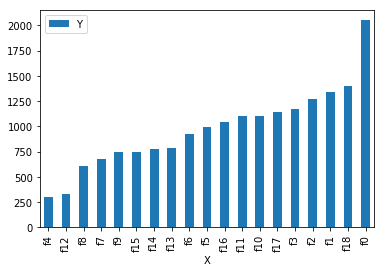

In [47]:
import matplotlib.pyplot as plt

fscores = DataFrame({'X': list(model2.get_fscore().keys()), 'Y': list(model2.get_fscore().values())})
fscores.sort_values(by='Y').plot.bar(x='X')